In [1]:
generate_profiling_reports = False
print_pair_plots = False

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import re
from io import StringIO
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

C:\Users\fhuel\miniconda3\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\fhuel\miniconda3\envs\tf\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: dev is an invalid version and will not be supported in a future release
  warnings.warn(


# Load the data

In [3]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [4]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys
def read_raw_data(file_path:str):
    with open(file_path) as file:
        data_string = file.read()
        data_string = data_string.replace("\n"," ")
        data_string = re.sub("[a-zA-Z]+ ","name\n", data_string)
        data_string = data_string.replace(" ",",")
        return data_string

In [5]:
# read the data from the specified datasets into the df
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(read_raw_data("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [6]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

In [7]:
# the uci encodes missing values as -9 we use np.float('nan') for better profiling reports
df = df.replace(-9, float('nan'))

# Analysis on all features including dropped once

In [8]:
if generate_profiling_reports:
    import pandas_profiling
    profile = pandas_profiling.ProfileReport(df, title='Pandas Profiling Report for the complete UCI dataset', explorative=True)
    profile.to_file("Pandas Profiling Report for all features.html")

## describe features for better overview

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,899.0,957.235818,1204.015482,1.00,116.000,266.00,1207.5,5002.0
ccf,899.0,0.000000,0.000000,0.00,0.000,0.00,0.0,0.0
age,899.0,53.480534,9.435894,28.00,47.000,54.00,60.0,77.0
sex,899.0,0.790879,0.406908,0.00,1.000,1.00,1.0,1.0
painloc,617.0,0.920583,0.270607,0.00,1.000,1.00,1.0,1.0
...,...,...,...,...,...,...,...,...
lvx3,880.0,1.132955,0.703837,1.00,1.000,1.00,1.0,8.0
lvx4,880.0,1.611364,1.722199,1.00,1.000,1.00,1.0,8.0
lvf,883.0,1.178935,0.512572,0.00,1.000,1.00,1.0,5.0
cathef,311.0,27.623119,31.675295,0.22,0.685,0.82,63.0,86.0


In [10]:
df.groupby('dataset').describe().transpose()

dataset      cleveland    hungarian  long-beach-va  switzerland
id   count  282.000000   294.000000     200.000000   123.000000
     mean   151.517730  1195.853741     101.310000  3625.886179
     std     87.131234   397.340367      58.717824   499.271374
     min      1.000000  1001.000000       1.000000  3001.000000
     25%     75.250000  1080.250000      50.750000  3031.500000
...                ...          ...            ...          ...
junk min           NaN          NaN       3.300000          NaN
     25%           NaN          NaN       4.800000          NaN
     50%           NaN          NaN       5.600000          NaN
     75%           NaN          NaN       6.900000          NaN
     max           NaN          NaN      11.300000          NaN

[600 rows x 4 columns]

## Through the high correlation in the pd-report check if dummy is equal to trestbps

In [11]:
print(f"dummy and trestpbs are equal for {df[df['dummy'] == df['trestbps']].shape[0]} measurements")
print(f"dummy and trestpbs are not equal for {df[df['dummy'] != df['trestbps']].shape[0]} measurements")

dummy and trestpbs are equal for 840 measurements
dummy and trestpbs are not equal for 59 measurements


It is assumed that these two variables are representing the same value. Dummy is therefor removed and because it is not explained by the UCI.

# Drop columns
## irrelevant_columns

In [12]:
irrelevant_columns = [
    "id", # A id is not relevant for a model
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "name" # Constant
]
df.drop(irrelevant_columns, inplace=True, axis=1)

## unexplained_columns

In [13]:
unexplained_columns = [
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "thalsev", # irrelevant according to the uci
    "thalpul", # irrelevant according to the uci
    "earlobe", # Constant
    "lvx1", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx2", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx3", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx4", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvf", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    'junk', # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "dummy" # same as trestbps
]
df.drop(unexplained_columns, inplace=True, axis=1)

## false predictors

In [14]:
# generate data for visualizing false predictors
X = df.loc[ : , (df.columns != 'num')&(df.columns != 'dataset')]
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
y[y> 1] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [15]:
# create and fit model
xgb = XGBClassifier(eval_metric= "auc")
xgb.fit(X_train, y_train, eval_set=eval_set)
results = xgb.evals_result()

[0]	validation_0-auc:0.99088	validation_1-auc:0.99096
[1]	validation_0-auc:0.99848	validation_1-auc:0.99692
[2]	validation_0-auc:0.99848	validation_1-auc:0.99692
[3]	validation_0-auc:0.99848	validation_1-auc:0.99692
[4]	validation_0-auc:0.99996	validation_1-auc:0.99952
[5]	validation_0-auc:0.99996	validation_1-auc:0.99943
[6]	validation_0-auc:0.99996	validation_1-auc:0.99929
[7]	validation_0-auc:0.99998	validation_1-auc:0.99901
[8]	validation_0-auc:0.99998	validation_1-auc:0.99915
[9]	validation_0-auc:1.00000	validation_1-auc:0.99920
[10]	validation_0-auc:1.00000	validation_1-auc:0.99915
[11]	validation_0-auc:1.00000	validation_1-auc:0.99903
[12]	validation_0-auc:1.00000	validation_1-auc:0.99903
[13]	validation_0-auc:1.00000	validation_1-auc:0.99913
[14]	validation_0-auc:1.00000	validation_1-auc:0.99913
[15]	validation_0-auc:1.00000	validation_1-auc:0.99913
[16]	validation_0-auc:1.00000	validation_1-auc:0.99908
[17]	validation_0-auc:1.00000	validation_1-auc:0.99903
[18]	validation_0-au

C:\Users\fhuel\miniconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\fhuel\miniconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


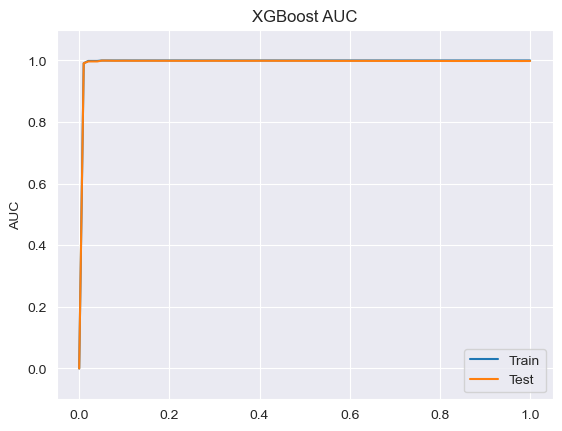

In [16]:
# create AUC plot
x_axis = np.arange(0, 1.001,0.01)
fig, ax = plt.subplots()
ax.plot(x_axis, [0]+results['validation_0']['auc'], label='Train')
ax.plot(x_axis, [0]+results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.ylim(-0.1, 1.1)
plt.savefig('XGBoost AUC.png', bbox_inches='tight')
plt.show()

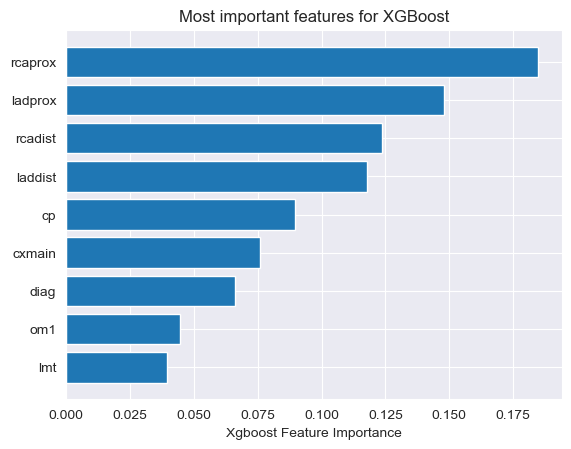

In [17]:
# create feature importance plot
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][-9:], xgb.feature_importances_[sorted_idx][-9:])
plt.xlabel("Xgboost Feature Importance")
plt.title('Most important features for XGBoost')
plt.savefig('Xgboost Feature Importance.png', bbox_inches='tight')
plt.show()

In [18]:
# calculate auc score for comparison
roc_auc_score(y_test, xgb.predict(X_test))

0.9795134737422974

In [19]:
false_predictors = [
    'lmt',      # Left main truck
    'ladprox',  # Proximal left anterior descending artery
    'laddist',  # Distal left anterior descending artery
    'diag',     # Diagonal branches
    'cxmain',   # Circumflex
    'ramus',    # Ramus intermedius
    'om1',      # First obtuse marginal branch
    'om2',      # Second obtuse marginal branch
    'rcaprox',  # Proximal right coronary artery
    'rcadist',  # Distal right coronary artery
]
df.drop(false_predictors, inplace=True, axis=1)

### Show impact of false predictors

In [20]:
# generate data for visualizing false predictors
X = df.loc[ : , (df.columns != 'num')&(df.columns != 'dataset')]
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
y[y> 1] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [21]:
# create and fit model
xgb = XGBClassifier(eval_metric= "auc")
xgb.fit(X_train, y_train, eval_set=eval_set)
results = xgb.evals_result()

[0]	validation_0-auc:0.94574	validation_1-auc:0.84052
[1]	validation_0-auc:0.96057	validation_1-auc:0.84225
[2]	validation_0-auc:0.97298	validation_1-auc:0.86103
[3]	validation_0-auc:0.98250	validation_1-auc:0.86864
[4]	validation_0-auc:0.98619	validation_1-auc:0.87812
[5]	validation_0-auc:0.99157	validation_1-auc:0.87508
[6]	validation_0-auc:0.99299	validation_1-auc:0.87496
[7]	validation_0-auc:0.99565	validation_1-auc:0.87375
[8]	validation_0-auc:0.99658	validation_1-auc:0.87108
[9]	validation_0-auc:0.99740	validation_1-auc:0.86901
[10]	validation_0-auc:0.99849	validation_1-auc:0.86814
[11]	validation_0-auc:0.99896	validation_1-auc:0.86837
[12]	validation_0-auc:0.99930	validation_1-auc:0.87340
[13]	validation_0-auc:0.99939	validation_1-auc:0.87437
[14]	validation_0-auc:0.99962	validation_1-auc:0.87464
[15]	validation_0-auc:0.99980	validation_1-auc:0.87451
[16]	validation_0-auc:0.99992	validation_1-auc:0.87405
[17]	validation_0-auc:0.99996	validation_1-auc:0.87391
[18]	validation_0-au

C:\Users\fhuel\miniconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\fhuel\miniconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


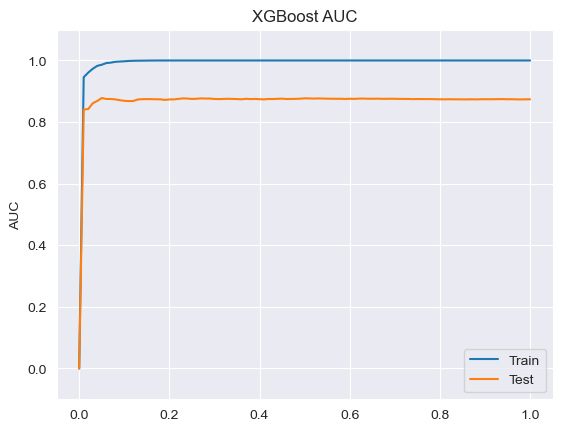

In [22]:
# create AUC plot
x_axis = np.arange(0, 1.001,0.01)
fig, ax = plt.subplots()
ax.plot(x_axis, [0]+results['validation_0']['auc'], label='Train')
ax.plot(x_axis, [0]+results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.ylim(-0.1, 1.1)
plt.show()

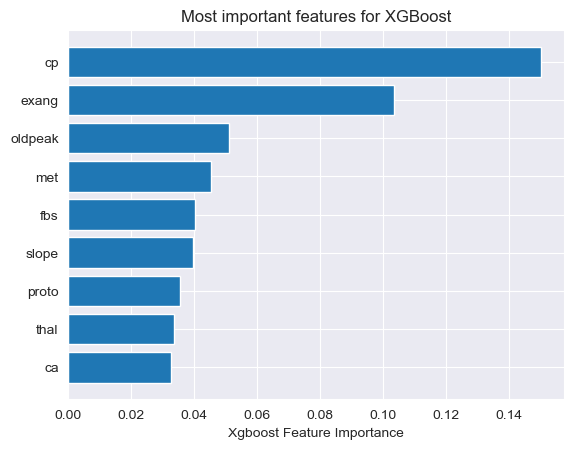

In [23]:
# generate feature importance plot
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][-9:], xgb.feature_importances_[sorted_idx][-9:])
plt.xlabel("Xgboost Feature Importance")
plt.title('Most important features for XGBoost')
plt.show()

In [24]:
# calculate auc score for comparison
roc_auc_score(y_test, xgb.predict(X_test))

0.8218522946748827

In [25]:
if generate_profiling_reports:
    profile = pandas_profiling.ProfileReport(df, title='Pandas Profiling Report for the used features from the UCI dataset', explorative=True)
    profile.to_file("Pandas Profiling Report for all used features.html")

# Analyse of Dataset
## PairPlots

In [26]:
# pairplots are only printed on used features
if print_pair_plots:
    df_pairplot = df.copy()
    df_pairplot.loc[df_pairplot['num'] > 1, 'num'] = 1
    sns.pairplot(df_pairplot, hue="num", palette="tab10")
    plt.savefig('pairplot with hue = num.png')
    sns.pairplot(df_pairplot, hue="dataset", palette="tab10")
    plt.savefig('pairplot with hue = dataset.png')

## Static Analysis

In [27]:
# Get the number of entries where the ST Depression was measured at a timepoint that is after than the exercise electrocardiogram
print(f"In {df[df['thaltime'] > df['thaldur']].shape[0]} cases the ST Depression was measured at a timepoint that is after than the exercise electrocardiogram")

In 25 cases the ST Depression was measured at a timepoint that is after than the exercise electrocardiogram


In [28]:
# Check heart rate for inconsistency
print(f"In {df.loc[df['thalach'] < df['thalrest'],['thalach','thalrest']].shape[0]} cases the maximum heartrate is lower than the resting heartrate")

In 1 cases the maximum heartrate is lower than the resting heartrate


The resting heart rate (thalrest) can not be lower than the maximum archived heart rate (thalach) because the thalach seems unrealisitc it is set to NaN later on.

## Explore how many NaNs and zeros are within one column for each attribute.

In [29]:
# How many values are 0
(df.loc[:, df.columns != 'dataset'].eq(0)).join(df['dataset']).groupby("dataset").sum()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restef,restwm,exeref,exerwm,thal,num,cathef
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,91,0,0,0,0,0,108,0,0,115,115,240,0,107,138,271,186,211,252,248,0,0,43,0,0,0,0,0,0,190,276,91,0,0,0,166,0,0,0,0,0,157,0
hungarian,0,81,23,164,141,0,0,195,0,10,0,0,266,0,1,235,293,274,265,269,290,0,0,0,0,0,0,0,0,0,204,291,189,0,0,0,3,0,3,0,2,0,188,0
long-beach-va,0,6,15,65,33,0,1,90,49,96,38,38,125,4,100,80,122,88,61,105,94,0,0,2,0,0,0,0,0,1,52,139,40,1,0,0,2,0,10,0,2,0,51,0
switzerland,0,10,11,22,27,0,0,60,123,5,0,0,43,0,0,85,116,70,75,66,93,0,0,25,0,0,0,0,0,0,68,113,42,0,0,0,0,0,0,0,0,0,8,0


The bloodpreasure (trestbps) of 0 needs to be handled.
The bloodpreasure (trestbpd) of 0 needs to be handled.
The cholesterin (chol) of 0 needs to be handled.
The slope 0 is not specified by UCI only 1-3 are valid

In [30]:
# How many values are NaN
(df.loc[:, df.columns != 'dataset'].isna()).join(df['dataset']).groupby("dataset").sum()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restef,restwm,exeref,exerwm,thal,num,cathef
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,282,282,282,0,0,0,0,282,5,5,0,259,0,0,2,2,2,2,2,0,0,69,0,0,0,0,0,0,0,0,0,0,282,0,2,282,282,282,282,2,0,282
hungarian,0,0,0,0,0,0,1,1,23,282,293,294,8,273,293,1,1,2,1,1,1,9,2,190,2,1,1,1,1,1,1,2,0,190,1,0,290,294,291,294,292,266,0,266
long-beach-va,0,0,0,0,4,0,56,3,7,5,10,12,7,157,8,0,60,60,59,59,73,53,53,160,53,53,54,59,59,56,53,53,56,101,65,65,198,172,173,198,197,159,0,23
switzerland,0,0,0,0,0,0,2,30,0,100,112,121,75,115,121,1,5,2,3,1,6,50,1,34,50,1,1,3,3,2,1,3,6,17,77,77,118,123,123,123,123,50,0,17


## outliers

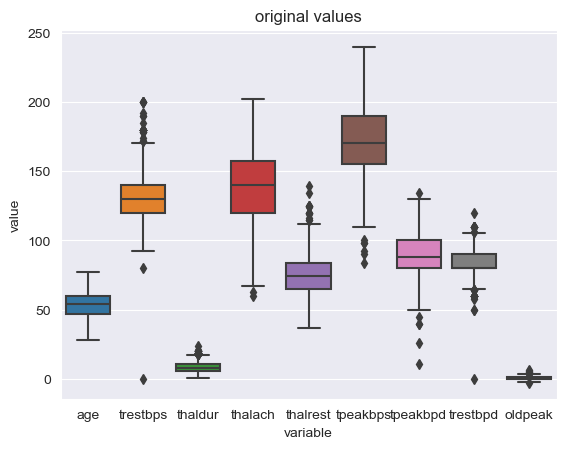

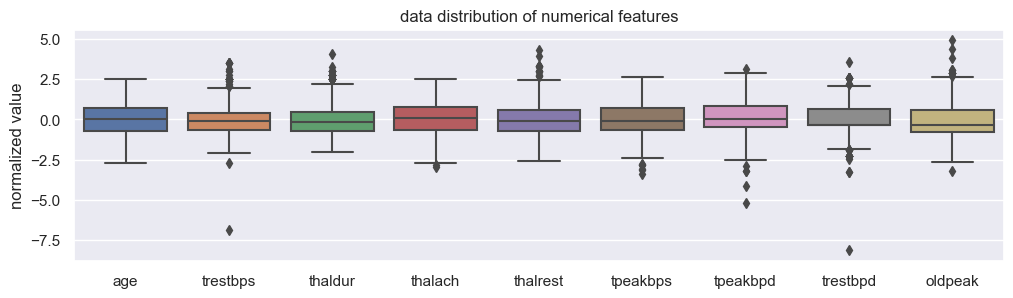

In [31]:
# get a subset of continuous variables
df_continous = df[["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"]]
# print unnormalised outlier plot
sns.boxplot(x="variable", y="value", data=pd.melt(df_continous))
plt.title("original values")
sns.set(rc={"figure.figsize":(12, 3)})
plt.show()
# Scale continuous variables to a mean of 0 and standarad deviation of 1
sc = StandardScaler()
df_continous = sc.fit_transform(df_continous)
df_continous = pd.DataFrame(df_continous, columns = ["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"])
# print box plot for identifying outliers
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_continous))
ax.set(xlabel='', ylabel='normalized value')
plt.title("data distribution of numerical features")
plt.show()

## Correlation
### Pearson Correlation for the complete dataset

C:\Users\fhuel\AppData\Local\Temp\ipykernel_30956\753981009.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


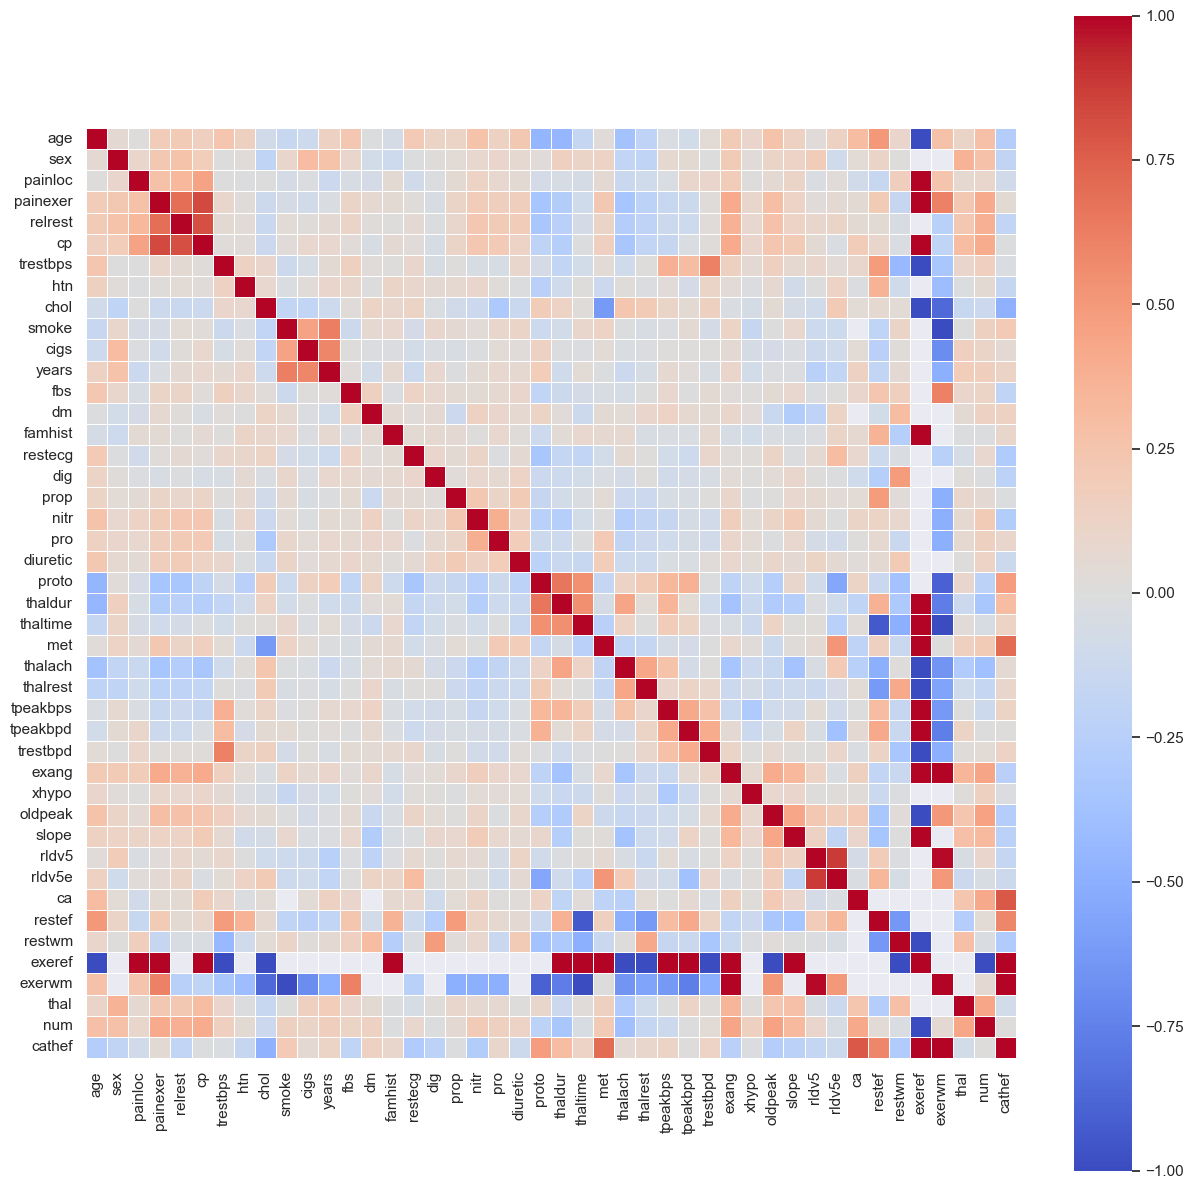

In [32]:
plt.figure(figsize=(15,15))
# Compute the correlation matrix
corr = df.corr()
corr = corr.round(2)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

### Pearson Correlation for evry origin within the dataset

C:\Users\fhuel\AppData\Local\Temp\ipykernel_30956\1875319475.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[df['dataset'] == dataset].corr()


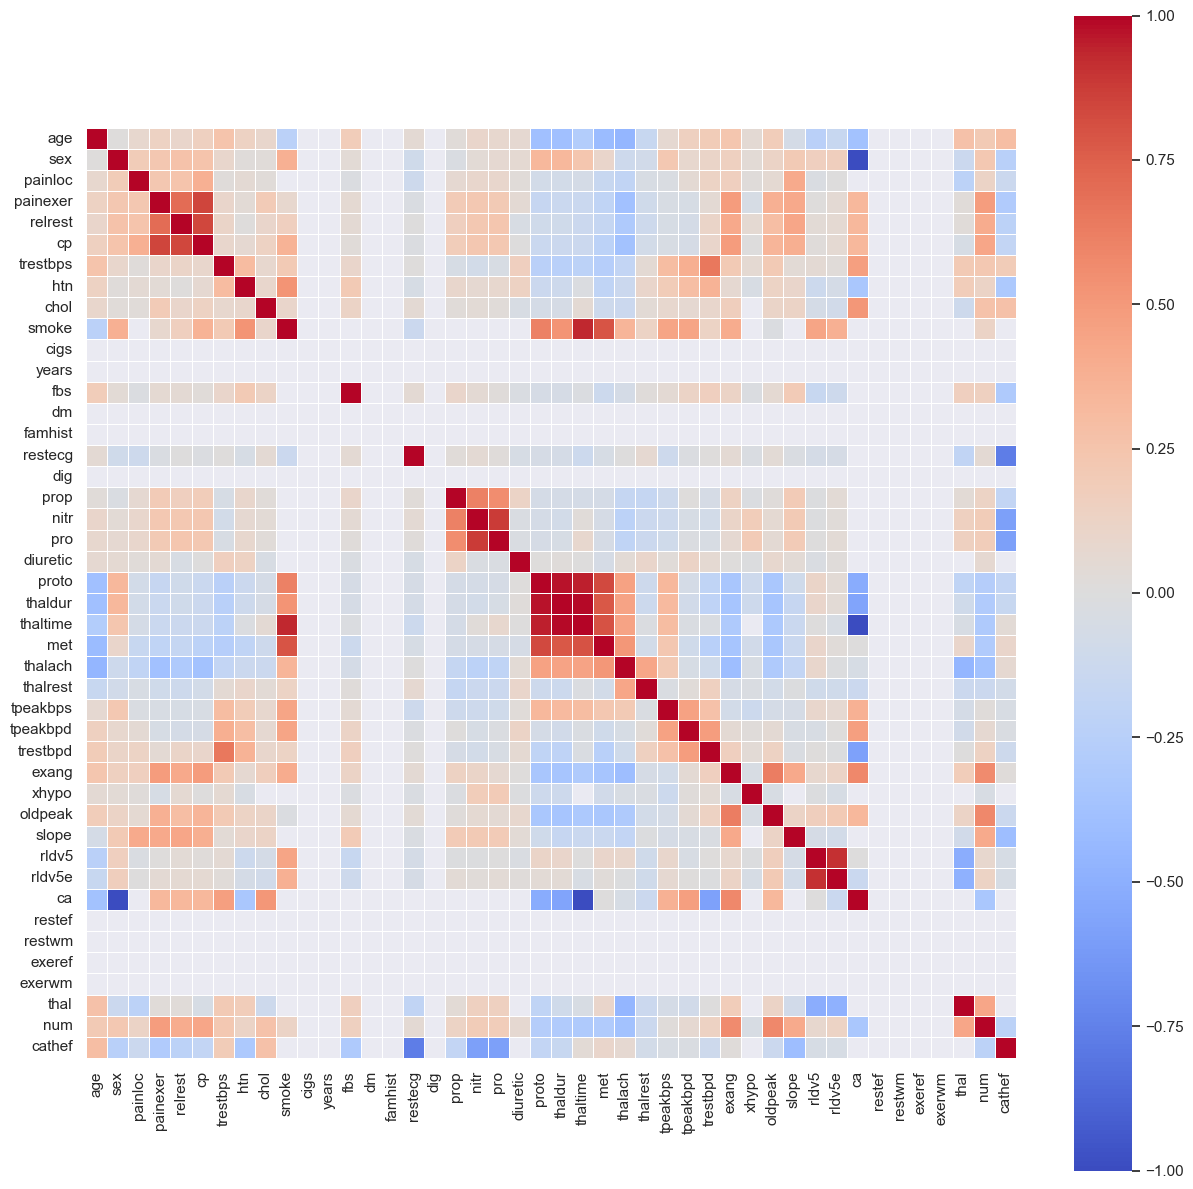

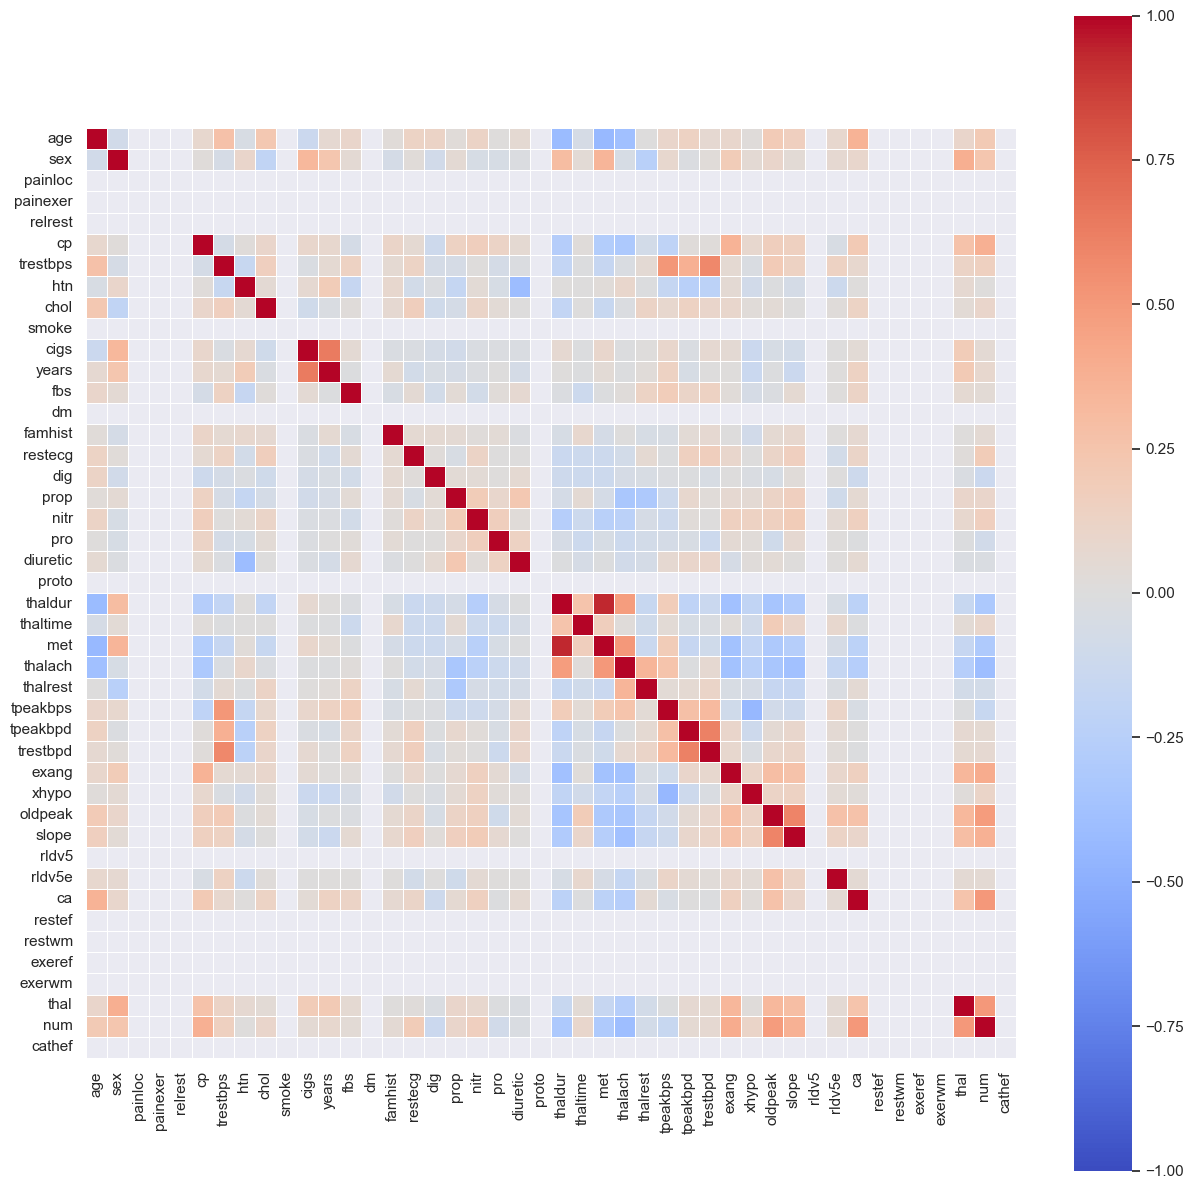

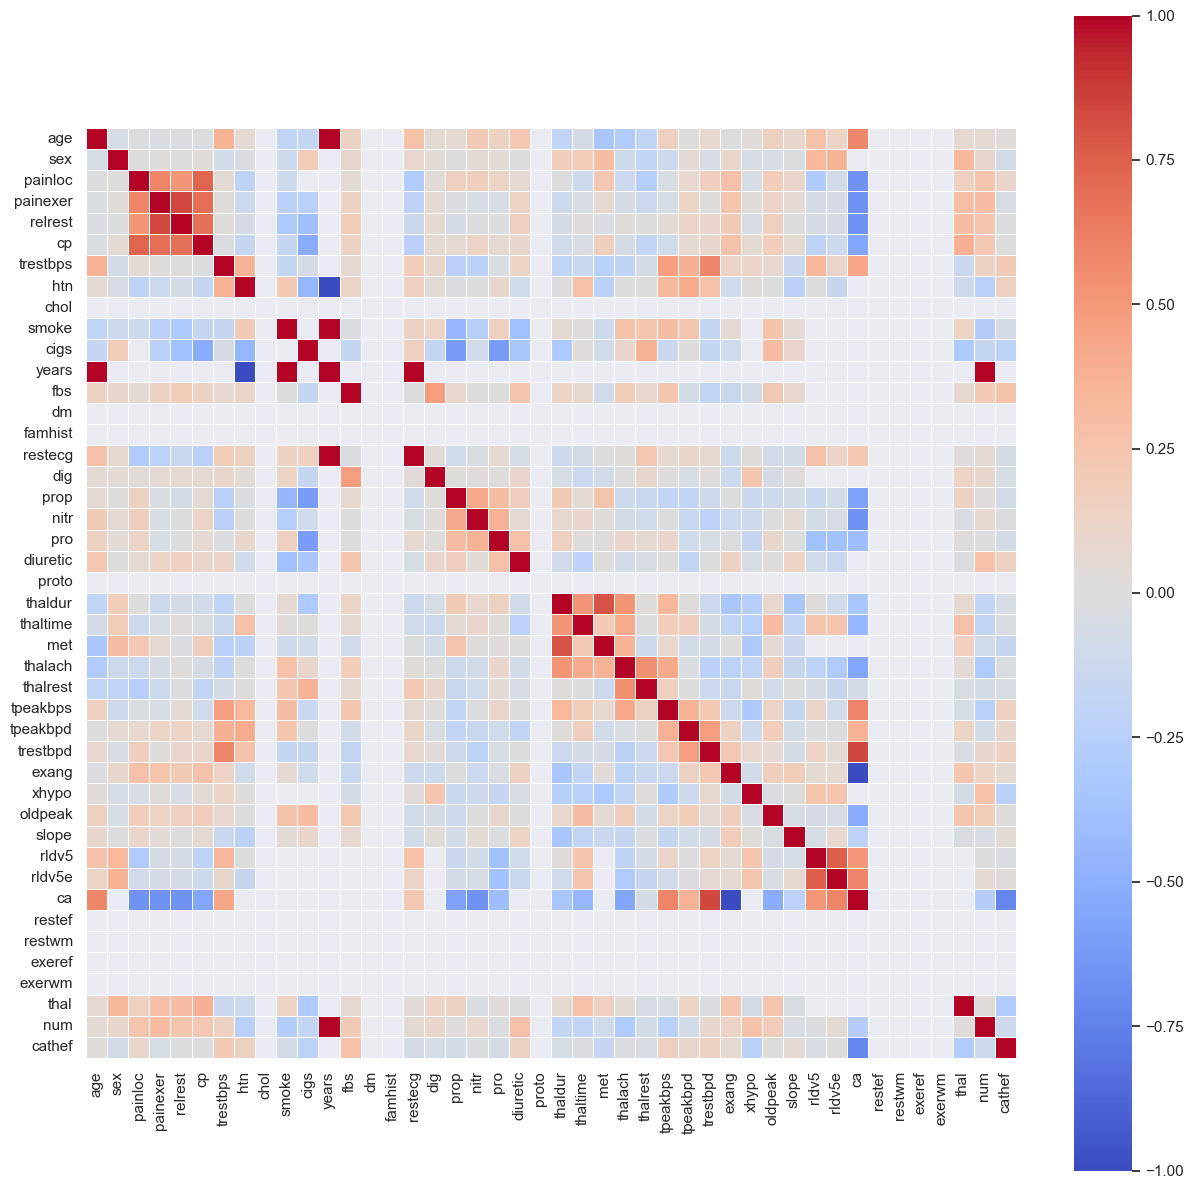

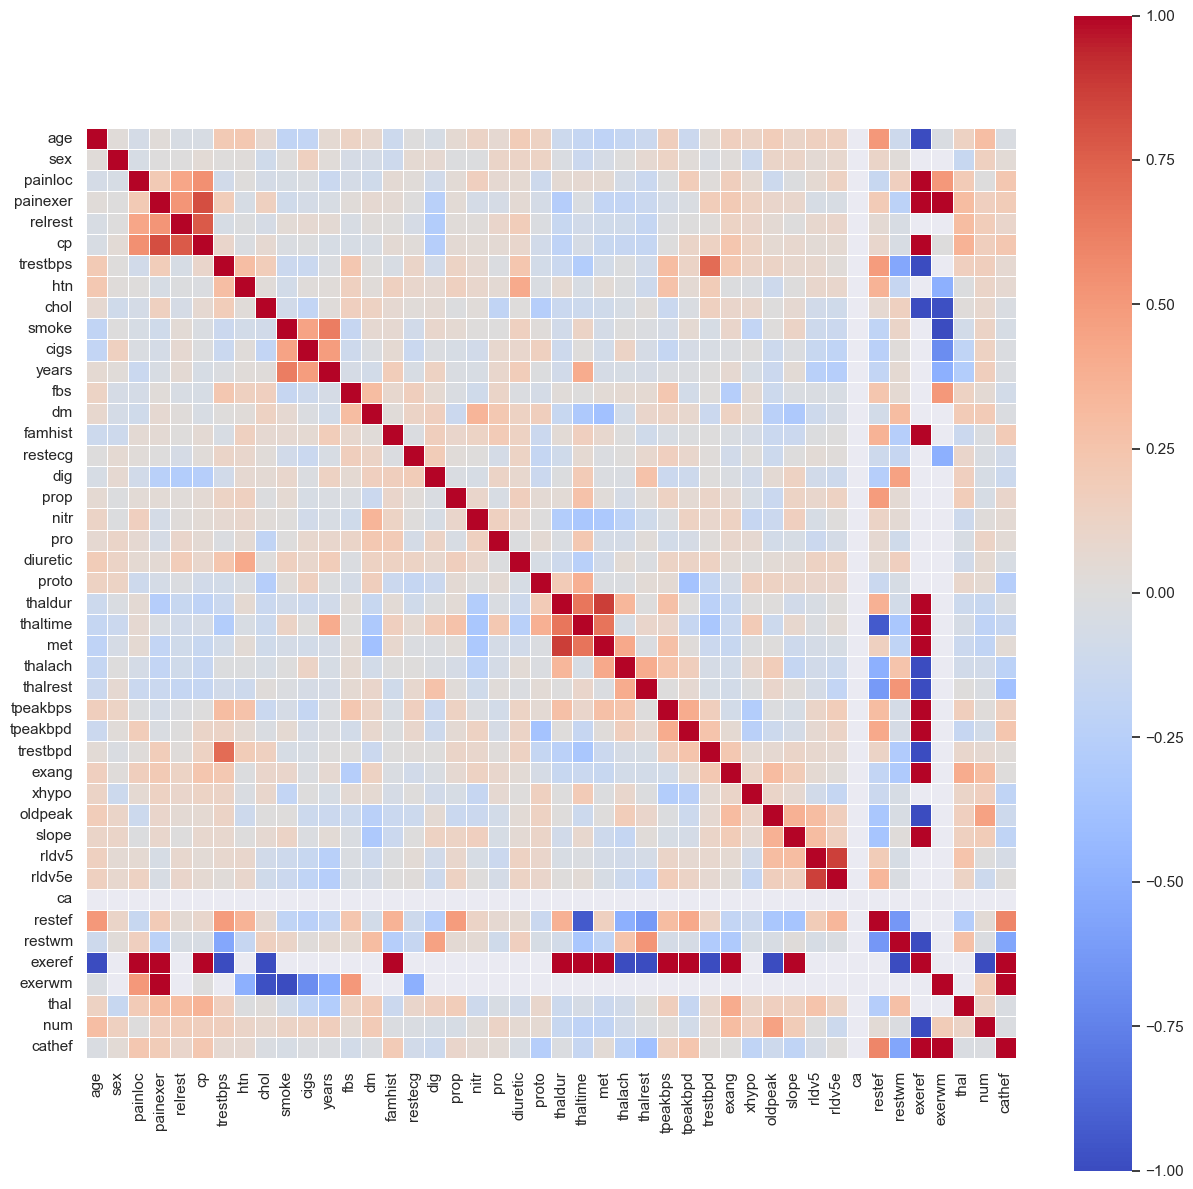

In [33]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    # Compute the correlation matrix
    corr = df[df['dataset'] == dataset].corr()
    corr = corr.round(2)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)
    plt.show()


In [34]:
percentage_missing = ((df.isna().sum()/len(df)*100).round(2)).to_dict()
test = {}
for percentage in np.arange(0,100,1):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).shape + (df.drop([*missing_vlaues.keys()], axis=1).isna().sum().sum(), )

### Analyse relevance of correlation
A Correlation is assumed to be irrelevant if more than 75% of a column is == NaN

In [35]:
df_correlation_relevance = df.copy()
# one hot encode features for realistic correlation use dummies for ease of use
for feature in ['cp','restecg', 'slope','ca', 'restwm']:
    df_correlation_relevance = pd.concat([df_correlation_relevance,pd.get_dummies(df_correlation_relevance[feature], prefix=feature)],axis=1)
    df_correlation_relevance.drop([feature],axis=1, inplace=True)
# calculate the percentage of missing cells per column
percentage_missing = ((df_correlation_relevance.isna().sum()/len(df_correlation_relevance)*100).round(2)).to_dict()

In [36]:
# extract tuples from df
df_correlation_relevance_unstacked = df_correlation_relevance.corr().unstack()
df_correlation_relevance_unstacked = df_correlation_relevance_unstacked.reset_index()
df_correlation_relevance_unstacked.columns = ["feature1","feature2","correlation"]
#remove duplicates and correlation between the same feature
df_correlation_relevance_unstacked = df_correlation_relevance_unstacked[df_correlation_relevance_unstacked['feature1'] < df_correlation_relevance_unstacked['feature2']]
# Add the percentage missing to the correlation df_correlation_relevance_unstacked
df_correlation_relevance_unstacked['percentage_missing_feature1'] = [percentage_missing[x] for x in df_correlation_relevance_unstacked['feature1']]
df_correlation_relevance_unstacked['percentage_missing_feature2'] = [percentage_missing[x] for x in df_correlation_relevance_unstacked['feature2']]
# generate absolute correlation for sorting
df_correlation_relevance_unstacked['abs_corr'] = abs(df_correlation_relevance_unstacked['correlation'])
# drop rows where at least one feature has more than 75% missing values or the correlation is smaller than 0.5 (irrelevant)
df_correlation_relevance_unstacked = df_correlation_relevance_unstacked[(df_correlation_relevance_unstacked["abs_corr"] > 0.5) & (df_correlation_relevance_unstacked['percentage_missing_feature1'] < 75) & (df_correlation_relevance_unstacked['percentage_missing_feature2'] < 75)]
# sort according to the absolute correlation and display
df_correlation_relevance_unstacked =df_correlation_relevance_unstacked.sort_values(by="abs_corr", ascending=False)
display(df_correlation_relevance_unstacked)

C:\Users\fhuel\AppData\Local\Temp\ipykernel_30956\3946007513.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_correlation_relevance_unstacked = df_correlation_relevance.corr().unstack()


,feature1,feature2,correlation,percentage_missing_feature1,percentage_missing_feature2,abs_corr
2481,cp_4,painexer,0.927771,0.00,31.37,0.927771
1861,rldv5,rldv5e,0.884520,47.27,15.80,0.884520
2482,cp_4,relrest,0.719787,0.00,31.81,0.719787
2364,cp_2,relrest,-0.712302,0.00,31.81,0.712302
2264,cathef,met,0.696134,65.41,11.68,0.696134
181,painexer,relrest,0.694375,31.37,31.81,0.694375
1141,proto,thaldur,0.663422,12.46,6.23,0.663422
2303,cp_1,painloc,-0.638315,0.00,31.37,0.638315
482,smoke,years,0.620703,74.42,48.05,0.620703
435,chol,met,-0.619028,3.34,11.68,0.619028


## Effect of enriching the smoke feature

In [37]:
def enrich_smoke(input_df):
    # we do not enrich smoke if cigs and years are conflicting

    # set all values of smoke that are NaN to 0 if the value of years is 0 and smoke does not indicate that the person smokes
    input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] == 0) & ~(input_df['cigs'] > 0),'smoke'] = 0
    # set all values of smoke that are NaN to 1 if the value of years is larger than 0 and smoke does not indicate that the person does not smoke
    input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] > 0) & (input_df['cigs'] != 0),'smoke'] = 1

    # set all values of smoke that are NaN to 0 if the value of smoke is 0 and years does not indicate that the person smokes
    input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] == 0) & ~(input_df['years'] > 0),'smoke'] = 0
    # set all values of smoke that are NaN to 1 if the value of cigs is larger than 0 and years does not indicate that the person does not smoke
    input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] > 0) & (input_df['years'] != 0),'smoke'] = 1
    return input_df
# calculate the percentage of missing values for smoke before enriching it
percentage_missing_pre = ((df["smoke"].isna().sum() / len(df) * 100).round(2))
df_enriched_smoke = enrich_smoke(df)
# calculate the percentage of missing values for smoke after enriching it
percentage_missing_post = ((df_enriched_smoke["smoke"].isna().sum() / len(df) * 100).round(2))
print(f"{percentage_missing_pre}% missing before enrichment")
print(f"{percentage_missing_post}% missing after enrichment:")

74.42% missing before enrichment
43.05% missing after enrichment:


The columns used for the enrichment are kept in the df because they provide a more detailed description of the smoking behaviour.

## Minimum percentage to be dropped
Minimum percentage to be dropped defines a threashold at wich a column is dopped when it has more than minimumPercentageToBeDropped missing features

In [38]:
df.shape

(899, 45)

In [39]:
percentage_missing = ((df.isna().sum()/len(df)*100).round(2)).to_dict()
# create a datafram containing the number of rows, number of columns and number of imputed cells for different minimum percentage to be dropped
df_minimum_percentage_to_be_dropped = {}
# iterate over different percentages
for percentage in np.arange(0,100,1):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    # get the number of rows and columns by extracting the shape after dropping. Append the number of imputed cells.
    df_minimum_percentage_to_be_dropped[percentage] = [*df.drop([*missing_vlaues.keys()], axis=1).shape, (df.drop([*missing_vlaues.keys()], axis=1).isna().sum().sum())]
# create df
df_minimum_percentage_to_be_dropped = pd.DataFrame.from_dict(df_minimum_percentage_to_be_dropped).transpose()
df_minimum_percentage_to_be_dropped.columns = ["number of rows", "number of columns", "number of imputed cells"]

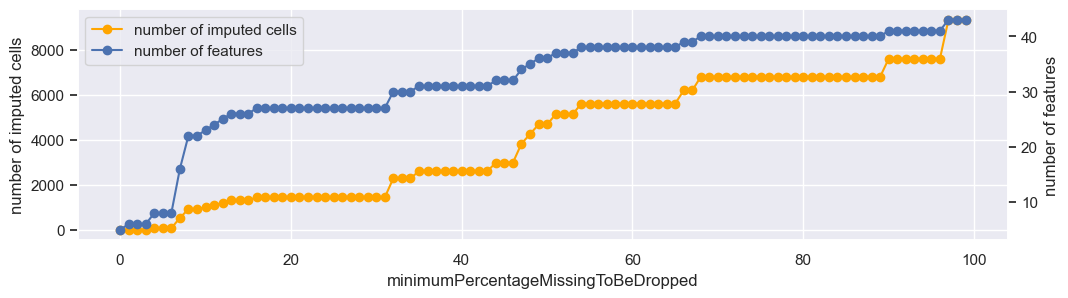

In [40]:
# generate plot showing the development of the number of imputed cells and number of remaining features over different minimumPercentageToBeDropped
# generate figure
fig, ax = plt.subplots(1)
ax2 = ax.twinx()
# generate line plots
lns1 = ax.plot(df_minimum_percentage_to_be_dropped.index, df_minimum_percentage_to_be_dropped["number of imputed cells"], '-o', label = 'number of imputed cells', color = 'orange')
lns2 = ax2.plot(df_minimum_percentage_to_be_dropped.index, df_minimum_percentage_to_be_dropped["number of columns"], '-o', label = 'number of features')
# label axis
ax.set_xlabel('minimumPercentageMissingToBeDropped')
ax.set_ylabel('number of imputed cells')
ax2.set_ylabel('number of features')
plt.grid()
# add legend
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
legend = ax.legend(lns, labs, loc=2, bbox_to_anchor=(0,1))
plt.show()

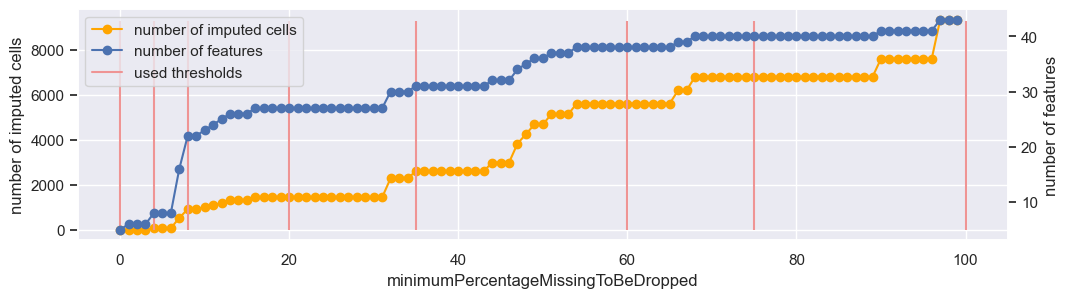

In [41]:
# generate plot showing the development of the number of imputed cells and number of remaining features over different minimumPercentageToBeDropped. Mark the used thresholds by vertical lines.
# generate figure
fig, ax = plt.subplots(1)
ax2 = ax.twinx()
# generate line plots
lns1 = ax.plot(df_minimum_percentage_to_be_dropped.index, df_minimum_percentage_to_be_dropped["number of imputed cells"], '-o', label = 'number of imputed cells', color = 'orange')
lns2 = ax2.plot(df_minimum_percentage_to_be_dropped.index, df_minimum_percentage_to_be_dropped["number of columns"], '-o', label = 'number of features')
#add decided thresholds
thresholds = [0,4,8,20,35,60,75,100]
for threshold in thresholds:
    ax.vlines(threshold,0,9300,color="#ef9494")
# label axis
ax.set_xlabel('minimumPercentageMissingToBeDropped')
ax.set_ylabel('number of imputed cells')
ax2.set_ylabel('number of features')
plt.grid()
# add legend
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
handles, labels = ax.get_legend_handles_labels()
lns.append(plt.Line2D([0],[0],markersize=10,color='#ef9494',label='thresholds'))
labs.append("used thresholds")
legend = ax.legend(lns, labs, loc=2, bbox_to_anchor=(0,1))
plt.show()

# Model visualisation

In [42]:
class DataframeSmokeTransformer:
    def transform(self, input_df, **transform_params):
        # we do not enrich smoke if cigs and years are conflicting

        # set all values of smoke that are NaN to 0 if the value of years is 0 and smoke does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] == 0) & ~(input_df['cigs'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of years is larger than 0 and smoke does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] > 0) & (input_df['cigs'] != 0),'smoke'] = 1

        # set all values of smoke that are NaN to 0 if the value of smoke is 0 and years does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] == 0) & ~(input_df['years'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of cigs is larger than 0 and years does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] > 0) & (input_df['years'] != 0),'smoke'] = 1
        return input_df
    def fit(self, X, y=None, **fit_params):
        # there is nothing to be fitted here because this handling is not split specific
        return self

In [43]:
class EnrichHeartData:
    def transform(self, input_df, **transform_params):
        input_df["heart_rate_diff"] = input_df['thalach'] - input_df['thalrest']
        input_df["rldv5_diff"] = input_df['rldv5'] - input_df['rldv5e']
        return input_df

    def fit(self, X, y=None, **fit_params):
        return self

In [44]:
from sklearn.exceptions import NotFittedError


class DropColumnsBasedOnMinimumPercentageToBeDropped:
    def __init__(self):
        self.minimum_percentage_to_be_dropped = 100
        self.fitted = False
        self.valuesToKeep = []

    def set_params(self, **params):
        self.minimum_percentage_to_be_dropped = params.get('minimum_percentage_to_be_dropped')

    def transform(self, input_df, **transform_params):
        if self.fitted:
            return input_df[input_df.columns.intersection(self.valuesToKeep)]
        else:
            raise NotFittedError()

    def fit(self, X, y=None, **fit_params):
        # calculate percentage of missing values for each column and store in a dictionary
        percentage_missing = (X.isna().sum()/len(df)*100).to_dict()
        # generate list of columns to keep
        self.valuesToKeep = [key for key, val in percentage_missing.items() if val <= self.minimum_percentage_to_be_dropped]
        self.fitted = True
        return self

In [45]:
class FixCommonEncodingErrors:
    def transform(self, input_df, **transform_params):
        input_df = input_df.copy(deep=True)
        # if cholesterin is 0 it was not measured
        input_df.loc[input_df['chol'] == 0,'chol'] =  np.float64("NaN")
        # leave the dead ones behind
        # drop entries with a blood pressure of 0
        input_df.loc[input_df['trestbps'] == 0,'trestbps'] =  np.float64("NaN")
        # is a binary variable (wrong measurement was detected in Pandas Profiling Report)
        input_df.loc[df['prop'].isin([0,1]) == False,'prop' ] = np.float64("NaN")
        # is a variable that has the values 0-3 by definition  (wrong measurement was detected in Pandas Profiling Report)
        input_df.loc[input_df['ca'] >3 ,'ca'] =  np.float64("NaN")
        # transform proto according to possible values from data/ask-detrano
        input_df.loc[input_df['proto'] == 200,'proto'] =  9
        input_df.loc[input_df['proto'] == 175,'proto'] =  8
        input_df.loc[input_df['proto'] == 150,'proto'] =  7
        input_df.loc[input_df['proto'] == 130,'proto'] =  6
        input_df.loc[input_df['proto'] == 125,'proto'] =  5
        input_df.loc[input_df['proto'] == 100,'proto'] = 4
        input_df.loc[input_df['proto'] == 75,'proto'] = 3
        input_df.loc[input_df['proto'] == 50,'proto'] = 2
        input_df.loc[input_df['proto'] == 25,'proto'] = 1
        #set all other values to NaN
        input_df.loc[input_df['proto'].isin([*range(1,13)]) == False, 'proto'] = np.float64("NaN")
        # the timepoint when the measurement was taken can not be larger than the time that the exercise took.
        input_df.loc[df['thaltime'] > df['thaldur'], 'thaltime'] = np.float64('NaN')
        # maximum archived heart rate can not  be lower than the heart rate at rest
        input_df.loc[input_df['thalach'] < input_df['thalrest'],'thalach'] = np.float64('NaN')

        return input_df
    def fit(self, X, y=None, **fit_params):
        return self

In [46]:
df.loc[df["num"]>1,'num'] = 1

In [47]:
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
one_hot_encoded_features = ['cp','restecg', 'slope','ca', 'restwm']
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
oneHotEncoder = ColumnTransformer(
    transformers=[
        ('discretize', KBinsDiscretizer(strategy='ordinal'), ['age']),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), lambda X : [value for value in one_hot_encoded_features if value in X.columns]),
    ], remainder='passthrough')
pipeline = Pipeline(steps=[
    ('fix_encoding_errors', FixCommonEncodingErrors()),
    ('transform_smoke', DataframeSmokeTransformer()),
    ('enrich_heart_rate', EnrichHeartData()),
    ('drop_columns', DropColumnsBasedOnMinimumPercentageToBeDropped()),
    ('oneHotEncoder', oneHotEncoder),
    ('impute', SimpleImputer()),
    ('scaler', 'passthrough'),
    ('sampler', 'passthrough'),
    ('estimator', DecisionTreeClassifier())
])
parameters = {
    'drop_columns__minimum_percentage_to_be_dropped' : 0,
    'estimator__criterion': "gini",
    'estimator__max_depth': None,
    'estimator__min_samples_split': 2,
    'impute__strategy':'mean',
    'oneHotEncoder__discretize': KBinsDiscretizer(2,encode='ordinal', strategy='uniform')
}
pipeline.set_params(**parameters)
pipeline.fit(X,y)

Pipeline(steps=[('fix_encoding_errors',
                 <__main__.FixCommonEncodingErrors object at 0x0000022B258F89D0>),
                ('transform_smoke',
                 <__main__.DataframeSmokeTransformer object at 0x0000022B24381360>),
                ('enrich_heart_rate',
                 <__main__.EnrichHeartData object at 0x0000022B23CEA0B0>),
                ('drop_columns',
                 <__main__.DropColumnsBasedOnMinimumPercentageToBeDropped object at 0x0000022B2...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('discretize',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=2,
                                                                   strategy='uniform'),
                                                  ['age']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <function <lambda> at 0x0000022B260105E0>)])),
                ('impute', SimpleImputer()), ('scaler', 'passthrough'),
                ('sampler', 'passthrough'),
                ('estimator', DecisionTreeClassifier())])

In [48]:
decision_tree = pipeline['estimator']

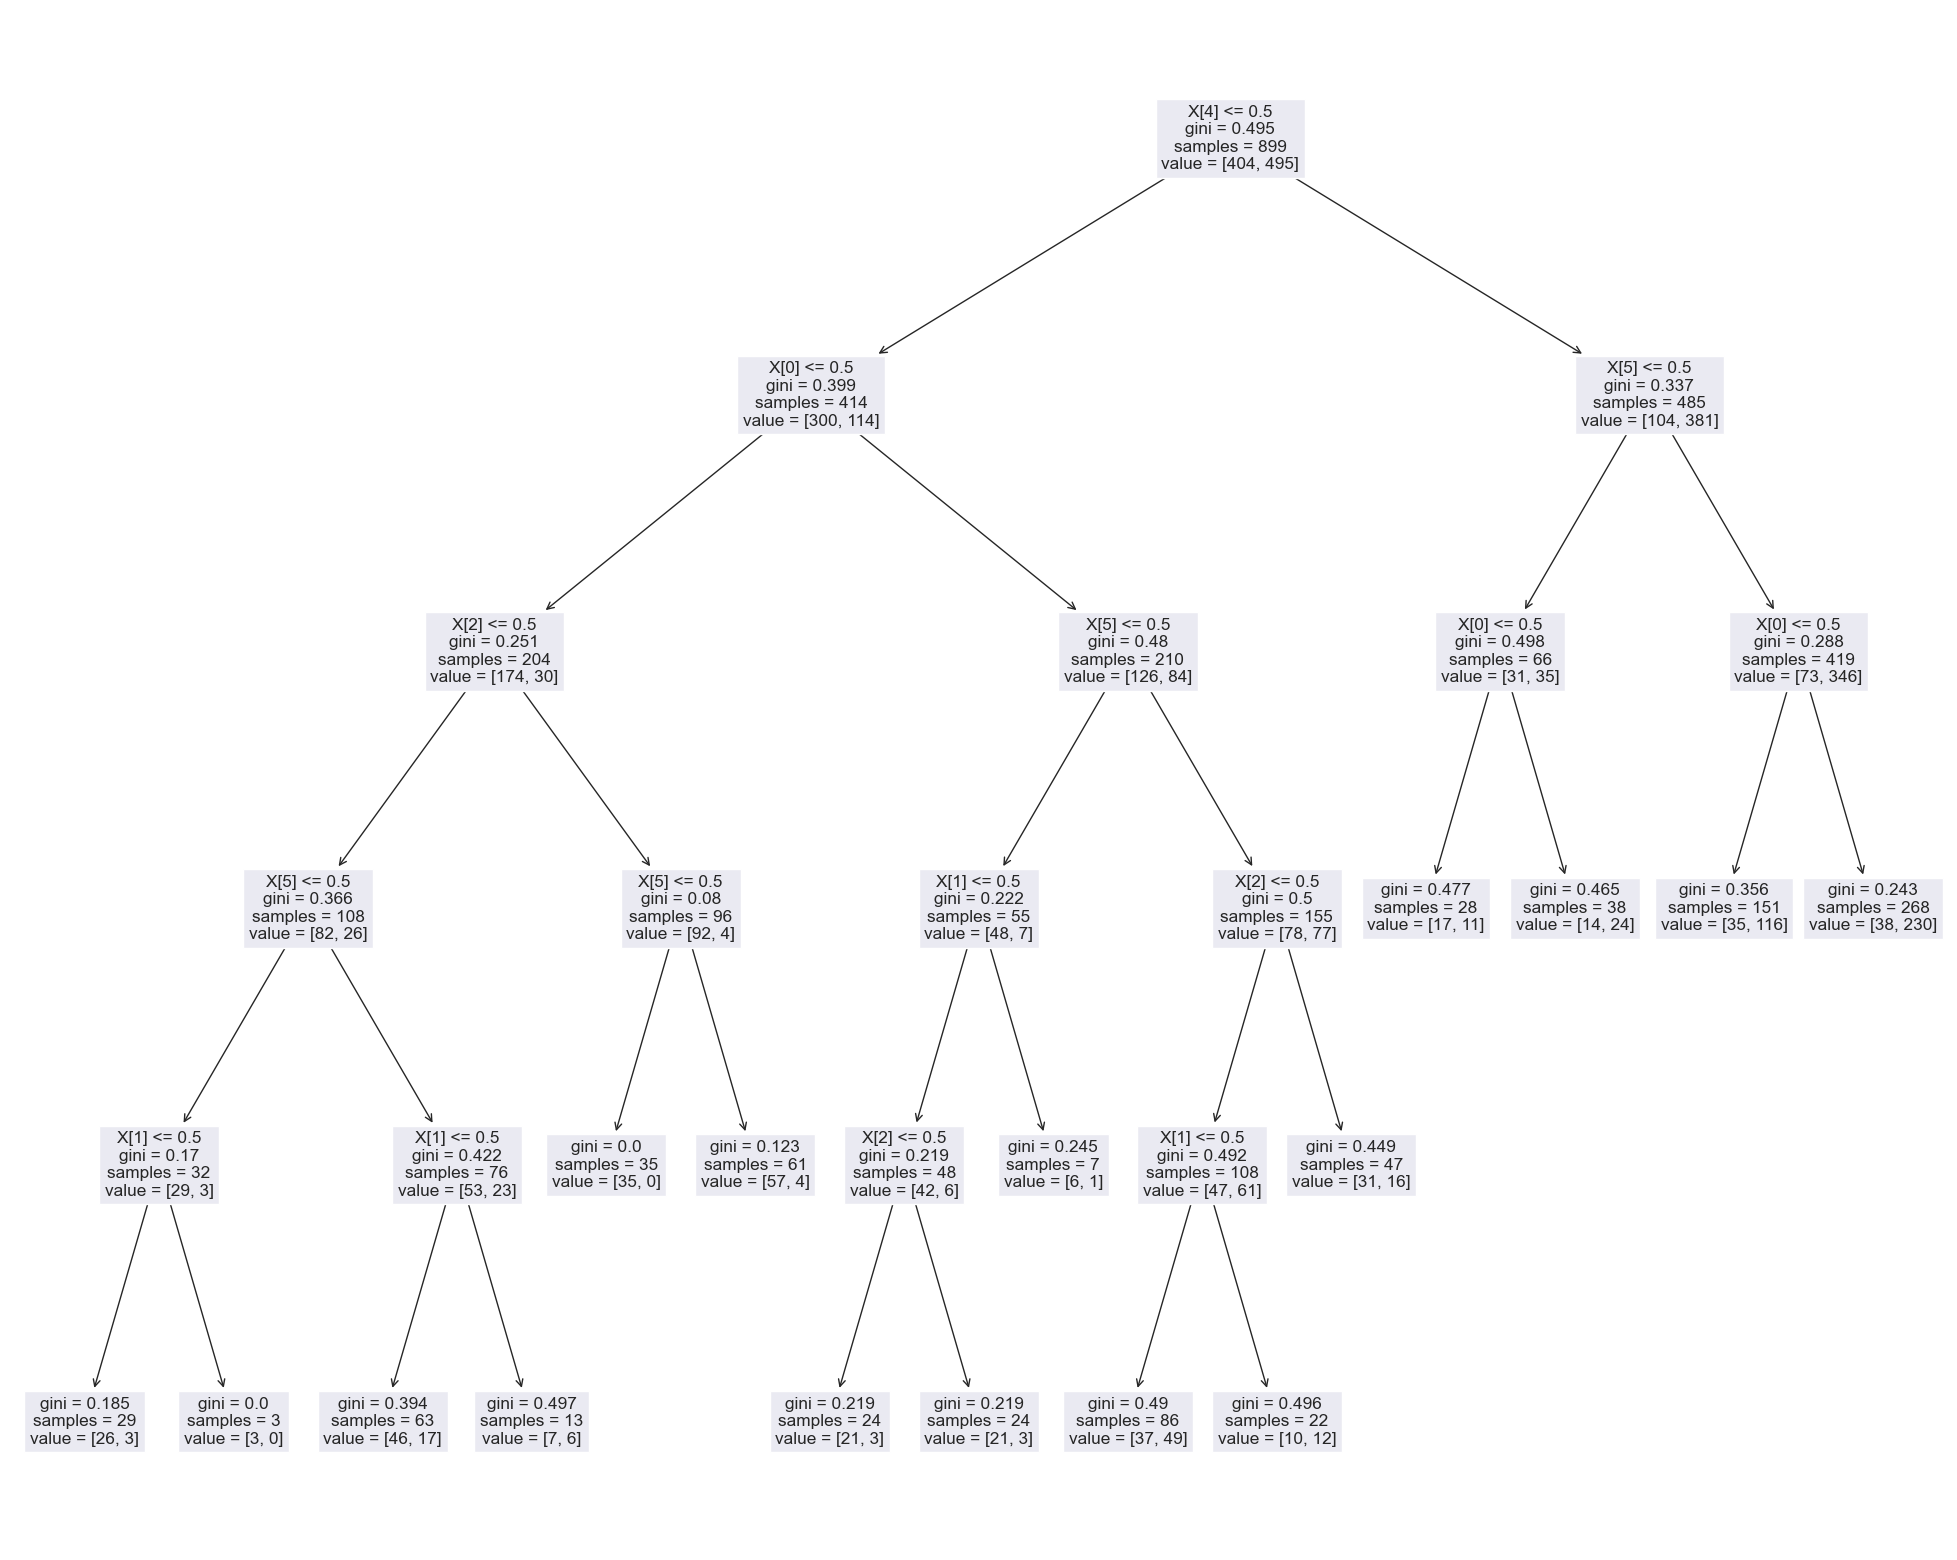

In [49]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree)


In [50]:
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
X_transformed = X.copy(deep=True)
X_transformed = FixCommonEncodingErrors().transform(X_transformed)
X_transformed = DataframeSmokeTransformer().transform(X_transformed)
X_transformed = EnrichHeartData().transform(X_transformed)
columnDropper = DropColumnsBasedOnMinimumPercentageToBeDropped()
columnDropper.set_params(**{'minimum_percentage_to_be_dropped':0})
columnDropper.fit(X)
X_transformed = columnDropper.transform(X_transformed)
# discretizer =  KBinsDiscretizer(2,encode='ordinal', strategy='uniform')
# X_transformed['age'] = discretizer.fit_transform(X_transformed['age'].to_numpy().reshape(-1, 1))
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
# one_hot_encoded_features = [value for value in one_hot_encoded_features if value in X_transformed.columns]
# encoded = pd.DataFrame(oneHotEncoder.fit_transform(X_transformed[one_hot_encoded_features]).toarray(), columns=oneHotEncoder.get_feature_names(one_hot_encoded_features))
# X_transformed = X_transformed.drop(columns=one_hot_encoded_features)
# X_transformed = X_transformed.join(encoded)
# imputer = SimpleImputer(strategy='mean')
# X_transformed = pd.DataFrame(imputer.fit_transform(X_transformed), columns=imputer.get_feature_names_out())
# scaler = MaxAbsScaler()
# X_transformed = pd.DataFrame(scaler.fit_transform(X_transformed), columns=scaler.get_feature_names_out())
# sampler = RandomUnderSampler(random_state=42)
# X_transformed, y = sampler.fit_resample(X_transformed,y)
decisionTreeClassifier = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
decisionTreeClassifier = decisionTreeClassifier.fit(X_transformed,y)

C:\Users\fhuel\miniconda3\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


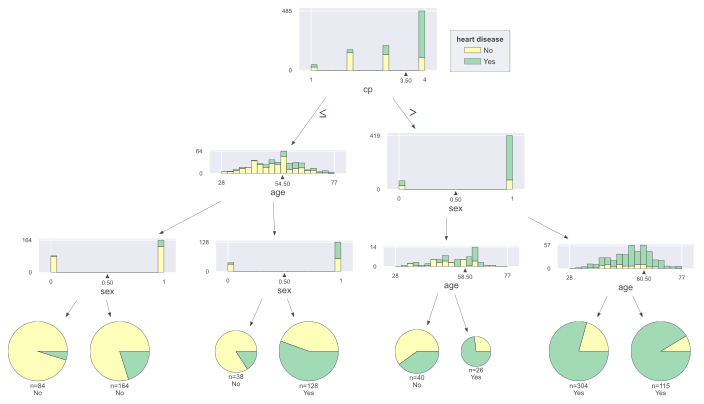

In [51]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(decisionTreeClassifier, X_transformed, y,
               target_name="heart disease",
               feature_names=X_transformed.columns,
               class_names=['No','Yes']
               )
viz

C:\Users\fhuel\miniconda3\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


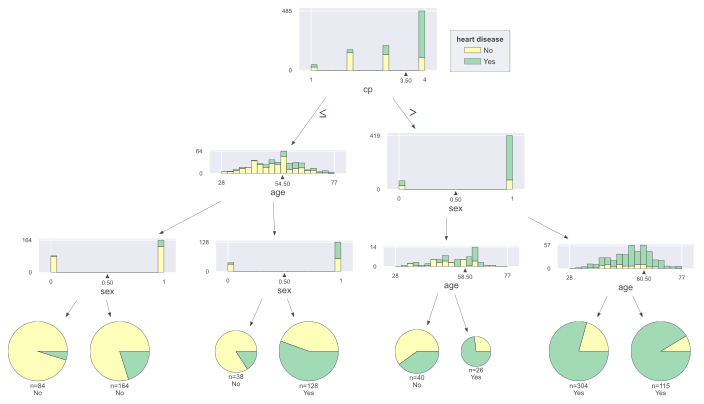

In [52]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(decisionTreeClassifier, X_transformed, y,
               target_name="heart disease",
               feature_names=X_transformed.columns,
               class_names=['No','Yes']
               )

viz


In [53]:
from sklearn.neighbors import KNeighborsClassifier
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
X_transformed = X.copy(deep=True)
X_transformed = FixCommonEncodingErrors().transform(X_transformed)
X_transformed = DataframeSmokeTransformer().transform(X_transformed)
X_transformed = EnrichHeartData().transform(X_transformed)
columnDropper = DropColumnsBasedOnMinimumPercentageToBeDropped()
columnDropper.set_params(**{'minimum_percentage_to_be_dropped':0})
columnDropper.fit(X)
X_transformed = columnDropper.transform(X_transformed)
discretizer =  KBinsDiscretizer(2,encode='ordinal', strategy='uniform')
X_transformed['age'] = discretizer.fit_transform(X_transformed['age'].to_numpy().reshape(-1, 1))
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
# one_hot_encoded_features = [value for value in one_hot_encoded_features if value in X_transformed.columns]
# encoded = pd.DataFrame(oneHotEncoder.fit_transform(X_transformed[one_hot_encoded_features]).toarray(), columns=oneHotEncoder.get_feature_names(one_hot_encoded_features))
# X_transformed = X_transformed.drop(columns=one_hot_encoded_features)
# X_transformed = X_transformed.join(encoded)
imputer = SimpleImputer(strategy='mean')
X_transformed = pd.DataFrame(imputer.fit_transform(X_transformed), columns=imputer.get_feature_names_out())
# scaler = MaxAbsScaler()
# X_transformed = pd.DataFrame(scaler.fit_transform(X_transformed), columns=scaler.get_feature_names_out())
# sampler = RandomUnderSampler(random_state=42)
# X_transformed, y = sampler.fit_resample(X_transformed,y)
kNeighborsClassifier = KNeighborsClassifier(n_neighbors=82,p=1, weights='distance')
kNeighborsClassifier = kNeighborsClassifier.fit(X_transformed,y)

TypeError: unsupported operand type(s) for &: 'float' and 'float'

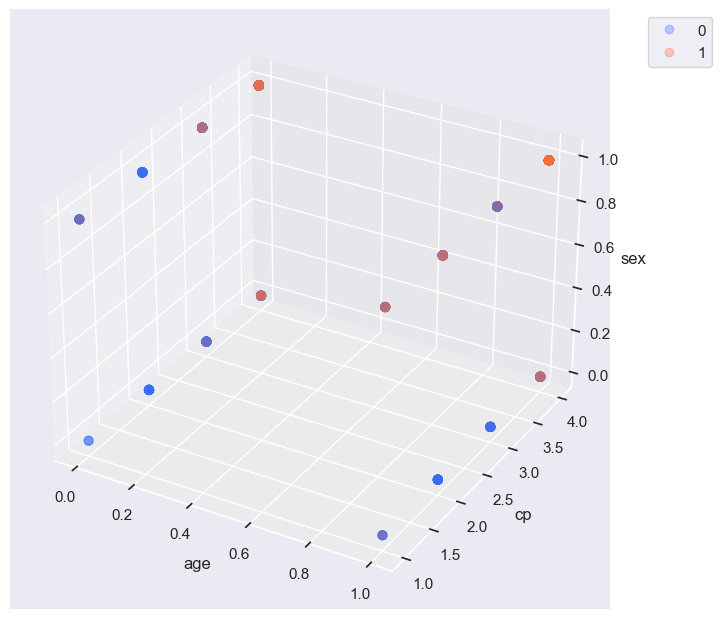

In [54]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
target = df.loc[: , (df.columns== 'num')].values.ravel().copy()
# generate data
n = 200
x = X_transformed['age']
y = X_transformed['cp']
z = X_transformed['sex']

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette('rainbow').as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=target, marker='o', cmap=cmap, alpha=0.3)
ax.set_xlabel('age')
ax.set_ylabel('cp')
ax.set_zlabel('sex')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)


#give the labels to each point
for x_label, y_label, z_label in zip(x, y, z):
    label = X_transformed[X_transformed['age'] == x & X_transformed['cp'] == y & X_transformed['sex'] == z]
    ax3d.text(x, y, z, label)
# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [ ]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
target = df.loc[: , (df.columns== 'num')].values.ravel().copy()
# generate data
x = X_transformed['age']
y = X_transformed['cp']
z = X_transformed['sex']

# axes instance
ax3d = plt.figure(figsize=(6,6)).gca(projection='3d')

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette('rainbow').as_hex())

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# plot
ax3d.scatter(x, y, z, s=40, c=target, marker='o', cmap=cmap, alpha=0.3)
ax3d.set_xlabel('age')
ax3d.set_ylabel('cp')
ax3d.set_zlabel('sex')


X_transformed['num'] = target

for index, row in X_transformed.groupby(['sex', 'cp','age']).count().reset_index().iterrows():
    ax3d.text(row['age'], row['cp'], row['sex'], int(row['num']))

plt.show()

In [ ]:
X['age'].describe()

In [ ]:
for current_x, current_y, current_z in zip(x, y, z):
    print(current_x, current_y, current_z)

In [ ]:
unstacked_corr = df_corr.corr().unstack()
#remove duplicate pairs
#index = pd.MultiIndex.from_tuples(tuples)
unstacked_corr = unstacked_corr.reset_index()
unstacked_corr.columns = ["feature1","feature2","correlation"]
#remove duplicates and correlation between the same feature
unstacked_corr = unstacked_corr[unstacked_corr['feature1'] < unstacked_corr['feature2']]
unstacked_corr['NaN_Values_feature1'] = [percentage_missing[x] for x in unstacked_corr['feature1']]
unstacked_corr['NaN_Values_feature2'] = [percentage_missing[x] for x in unstacked_corr['feature2']]
unstacked_corr['abs_corr'] = abs(unstacked_corr['correlation'])
unstacked_corr = unstacked_corr[(abs(unstacked_corr["correlation"]) > 0.5) & (unstacked_corr['NaN_Values_feature1'] < 75) & (unstacked_corr['NaN_Values_feature2'] < 75)].sort_values(by="abs_corr", ascending=False)
unstacked_corr.drop(["abs_corr"], inplace=True, axis=1)
print(unstacked_corr)

In [ ]:
cp_4VSpainexer = pd.crosstab(df_corr['cp_4'], df_corr['painexer'], rownames=['cp_4'], colnames=['painexer'])
cpVSpainexer = pd.crosstab(df['cp'], df['painexer'], rownames=['cp_4'], colnames=['painexer'])
print(cp_4VSpainexer)
print("------------------------------------")
print(cpVSpainexer)

## PairPlots

# minimumPercentageToBeDropped

In [ ]:
print_pair_plots = False #was missing
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")
if print_pair_plots:
    sns.pairplot(df, hue="dataset", palette="tab10")

In [ ]:
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns", "number of imputed cells"]

In [ ]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1)
ax.grid()
#add decided thresholds
thresholds = [0,4,8,20,35,60,75,100]
for threshold in thresholds:
    ax.vlines(threshold,0,80000,color="#ef9494")

lns1 = ax.plot(test.index, test["number of imputed cells"], '-o', label = 'number of imputed cells', color = 'orange')
ax2 = ax.twinx()
lns2 = ax2.plot(test.index, test["columns"], '-o', label = 'n features')

ax.set_xlabel('minimumPercentageMissingToBeDropped')
ax.set_ylabel('number of imputed cells')
ax2.set_ylabel('n features')


# added these three lines
lns = lns1 + lns2
labs = [l.get_label() for l in lns]

handles, labels = ax.get_legend_handles_labels()
lns.append(Line2D([0],[0],markersize=10,color='#ef9494',label='thresholds'))
labs.append("Color Patch")

legend = ax.legend(lns, labs, loc=2, bbox_to_anchor=(0,1))

plt.show()

In [ ]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1)
ax.grid()
lns1 = ax.plot(test.index, test["number of imputed cells"], '-o', label = 'number of imputed cells', color = 'orange')
ax2 = ax.twinx()
lns2 = ax2.plot(test.index, test["columns"], '-o', label = 'n features')

ax.set_xlabel('minimumPercentageMissingToBeDropped')
ax.set_ylabel('number of imputed cells')
ax2.set_ylabel('n features')


# added these three lines
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
legend = ax.legend(lns, labs, loc=2, bbox_to_anchor=(0,1))

plt.show()

In [ ]:
percentage_missing = ((df.isna().sum() / len(df) * 100).round(2)).to_dict()
test = {}
for percentage in np.arange(0, 100, 10):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).dropna(axis=0, how='any').shape
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns"]

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1 = sns.lineplot(data=test, y="columns", x=test.index, ax=ax1, color="orange", marker='o')
ax2 = sns.lineplot(data=test, y="rows", x=test.index, ax=ax2, color="blue", marker='o')
ax1.set_ylabel('n features')
ax1.set_xlabel('minimumPercentageMissingToBeDropped')
ax2.set_ylabel('n datapoints')
ax1.figure.legend(['features','datapoints'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax1.transAxes)
plt.show()

# Model visualisation

In [ ]:
class DataframeSmokeTransformer:
    def transform(self, input_df, **transform_params):
        # we do not enrich smoke if cigs and years are conflicting

        # set all values of smoke that are NaN to 0 if the value of years is 0 and smoke does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] == 0) & ~(input_df['cigs'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of years is larger than 0 and smoke does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] > 0) & (input_df['cigs'] != 0),'smoke'] = 1

        # set all values of smoke that are NaN to 0 if the value of smoke is 0 and years does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] == 0) & ~(input_df['years'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of cigs is larger than 0 and years does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] > 0) & (input_df['years'] != 0),'smoke'] = 1
        return input_df
    def fit(self, X, y=None, **fit_params):
        # there is nothing to be fitted here because this handling is not split specific
        return self

In [ ]:
class EnrichHeartData:
    def transform(self, input_df, **transform_params):
        input_df["heart_rate_diff"] = input_df['thalach'] - input_df['thalrest']
        input_df["rldv5_diff"] = input_df['rldv5'] - input_df['rldv5e']
        return input_df

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
from sklearn.exceptions import NotFittedError


class DropColumnsBasedOnMinimumPercentageToBeDropped:
    def __init__(self):
        self.minimum_percentage_to_be_dropped = 100
        self.fitted = False
        self.valuesToKeep = []

    def set_params(self, **params):
        self.minimum_percentage_to_be_dropped = params.get('minimum_percentage_to_be_dropped')

    def transform(self, input_df, **transform_params):
        if self.fitted:
            return input_df[input_df.columns.intersection(self.valuesToKeep)]
        else:
            raise NotFittedError()

    def fit(self, X, y=None, **fit_params):
        # calculate percentage of missing values for each column and store in a dictionary
        percentage_missing = (X.isna().sum()/len(df)*100).to_dict()
        # generate list of columns to keep
        self.valuesToKeep = [key for key, val in percentage_missing.items() if val <= self.minimum_percentage_to_be_dropped]
        self.fitted = True
        return self

In [ ]:
class FixCommonEncodingErrors:
    def transform(self, input_df, **transform_params):
        input_df = input_df.copy(deep=True)
        # if cholesterin is 0 it was not measured
        input_df.loc[input_df['chol'] == 0,'chol'] =  np.float64("NaN")
        # leave the dead ones behind
        # drop entries with a blood pressure of 0
        input_df.loc[input_df['trestbps'] == 0,'trestbps'] =  np.float64("NaN")
        # is a binary variable (wrong measurement was detected in Pandas Profiling Report)
        input_df.loc[df['prop'].isin([0,1]) == False,'prop' ] = np.float64("NaN")
        # is a variable that has the values 0-3 by definition  (wrong measurement was detected in Pandas Profiling Report)
        input_df.loc[input_df['ca'] >3 ,'ca'] =  np.float64("NaN")
        # transform proto according to possible values from data/ask-detrano
        input_df.loc[input_df['proto'] == 200,'proto'] =  9
        input_df.loc[input_df['proto'] == 175,'proto'] =  8
        input_df.loc[input_df['proto'] == 150,'proto'] =  7
        input_df.loc[input_df['proto'] == 130,'proto'] =  6
        input_df.loc[input_df['proto'] == 125,'proto'] =  5
        input_df.loc[input_df['proto'] == 100,'proto'] = 4
        input_df.loc[input_df['proto'] == 75,'proto'] = 3
        input_df.loc[input_df['proto'] == 50,'proto'] = 2
        input_df.loc[input_df['proto'] == 25,'proto'] = 1
        #set all other values to NaN
        input_df.loc[input_df['proto'].isin([*range(1,13)]) == False, 'proto'] = np.float64("NaN")
        # the timepoint when the measurement was taken can not be larger than the time that the exercise took.
        input_df.loc[df['thaltime'] > df['thaldur'], 'thaltime'] = np.float64('NaN')
        # maximum archived heart rate can not  be lower than the heart rate at rest
        input_df.loc[input_df['thalach'] < input_df['thalrest'],'thalach'] = np.float64('NaN')

        return input_df
    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
df.loc[df["num"]>1,'num'] = 1

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
one_hot_encoded_features = ['cp','restecg', 'slope','ca', 'restwm']
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
oneHotEncoder = ColumnTransformer(
    transformers=[
        ('discretize', KBinsDiscretizer(strategy='ordinal'), ['age']),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), lambda X : [value for value in one_hot_encoded_features if value in X.columns]),
    ], remainder='passthrough')
pipeline = Pipeline(steps=[
    ('fix_encoding_errors', FixCommonEncodingErrors()),
    ('transform_smoke', DataframeSmokeTransformer()),
    ('enrich_heart_rate', EnrichHeartData()),
    ('drop_columns', DropColumnsBasedOnMinimumPercentageToBeDropped()),
    ('oneHotEncoder', oneHotEncoder),
    ('impute', SimpleImputer()),
    ('scaler', 'passthrough'),
    ('sampler', 'passthrough'),
    ('estimator', DecisionTreeClassifier())
])
parameters = {
    'drop_columns__minimum_percentage_to_be_dropped' : 0,
    'estimator__criterion': "gini",
    'estimator__max_depth': None,
    'estimator__min_samples_split': 2,
    'impute__strategy':'mean',
    'oneHotEncoder__discretize': KBinsDiscretizer(2,encode='ordinal', strategy='uniform')
}
pipeline.set_params(**parameters)
pipeline.fit(X,y)

In [ ]:
decision_tree = pipeline['estimator']

In [ ]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree)


In [ ]:
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
X_transformed = X.copy(deep=True)
X_transformed = FixCommonEncodingErrors().transform(X_transformed)
X_transformed = DataframeSmokeTransformer().transform(X_transformed)
X_transformed = EnrichHeartData().transform(X_transformed)
columnDropper = DropColumnsBasedOnMinimumPercentageToBeDropped()
columnDropper.set_params(**{'minimum_percentage_to_be_dropped':0})
columnDropper.fit(X)
X_transformed = columnDropper.transform(X_transformed)
# discretizer =  KBinsDiscretizer(2,encode='ordinal', strategy='uniform')
# X_transformed['age'] = discretizer.fit_transform(X_transformed['age'].to_numpy().reshape(-1, 1))
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
# one_hot_encoded_features = [value for value in one_hot_encoded_features if value in X_transformed.columns]
# encoded = pd.DataFrame(oneHotEncoder.fit_transform(X_transformed[one_hot_encoded_features]).toarray(), columns=oneHotEncoder.get_feature_names(one_hot_encoded_features))
# X_transformed = X_transformed.drop(columns=one_hot_encoded_features)
# X_transformed = X_transformed.join(encoded)
# imputer = SimpleImputer(strategy='mean')
# X_transformed = pd.DataFrame(imputer.fit_transform(X_transformed), columns=imputer.get_feature_names_out())
# scaler = MaxAbsScaler()
# X_transformed = pd.DataFrame(scaler.fit_transform(X_transformed), columns=scaler.get_feature_names_out())
# sampler = RandomUnderSampler(random_state=42)
# X_transformed, y = sampler.fit_resample(X_transformed,y)
decisionTreeClassifier = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
decisionTreeClassifier = decisionTreeClassifier.fit(X_transformed,y)

In [ ]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(decisionTreeClassifier, X_transformed, y,
               target_name="heart disease",
               feature_names=X_transformed.columns,
               class_names=['No','Yes']
               )
viz

In [ ]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(decisionTreeClassifier, X_transformed, y,
               target_name="heart disease",
               feature_names=X_transformed.columns,
               class_names=['No','Yes']
               )

viz


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()
X_transformed = X.copy(deep=True)
X_transformed = FixCommonEncodingErrors().transform(X_transformed)
X_transformed = DataframeSmokeTransformer().transform(X_transformed)
X_transformed = EnrichHeartData().transform(X_transformed)
columnDropper = DropColumnsBasedOnMinimumPercentageToBeDropped()
columnDropper.set_params(**{'minimum_percentage_to_be_dropped':0})
columnDropper.fit(X)
X_transformed = columnDropper.transform(X_transformed)
discretizer =  KBinsDiscretizer(2,encode='ordinal', strategy='uniform')
X_transformed['age'] = discretizer.fit_transform(X_transformed['age'].to_numpy().reshape(-1, 1))
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
# one_hot_encoded_features = [value for value in one_hot_encoded_features if value in X_transformed.columns]
# encoded = pd.DataFrame(oneHotEncoder.fit_transform(X_transformed[one_hot_encoded_features]).toarray(), columns=oneHotEncoder.get_feature_names(one_hot_encoded_features))
# X_transformed = X_transformed.drop(columns=one_hot_encoded_features)
# X_transformed = X_transformed.join(encoded)
imputer = SimpleImputer(strategy='mean')
X_transformed = pd.DataFrame(imputer.fit_transform(X_transformed), columns=imputer.get_feature_names_out())
# scaler = MaxAbsScaler()
# X_transformed = pd.DataFrame(scaler.fit_transform(X_transformed), columns=scaler.get_feature_names_out())
# sampler = RandomUnderSampler(random_state=42)
# X_transformed, y = sampler.fit_resample(X_transformed,y)
kNeighborsClassifier = KNeighborsClassifier(n_neighbors=82,p=1, weights='distance')
kNeighborsClassifier = kNeighborsClassifier.fit(X_transformed,y)

In [ ]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
target = df.loc[: , (df.columns== 'num')].values.ravel().copy()
# generate data
n = 200
x = X_transformed['age']
y = X_transformed['cp']
z = X_transformed['sex']

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette('rainbow').as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=target, marker='o', cmap=cmap, alpha=0.3)
ax.set_xlabel('age')
ax.set_ylabel('cp')
ax.set_zlabel('sex')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)


#give the labels to each point
for x_label, y_label, z_label in zip(x, y, z):
    label = X_transformed[X_transformed['age'] == x & X_transformed['cp'] == y & X_transformed['sex'] == z]
    ax3d.text(x, y, z, label)
# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [ ]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
target = df.loc[: , (df.columns== 'num')].values.ravel().copy()
# generate data
x = X_transformed['age']
y = X_transformed['cp']
z = X_transformed['sex']

# axes instance
ax3d = plt.figure(figsize=(6,6)).gca(projection='3d')

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette('rainbow').as_hex())

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# plot
ax3d.scatter(x, y, z, s=40, c=target, marker='o', cmap=cmap, alpha=0.3)
ax3d.set_xlabel('age')
ax3d.set_ylabel('cp')
ax3d.set_zlabel('sex')


X_transformed['num'] = target

for index, row in X_transformed.groupby(['sex', 'cp','age']).count().reset_index().iterrows():
    ax3d.text(row['age'], row['cp'], row['sex'], int(row['num']))

plt.show()

In [ ]:
X['age'].describe()

In [ ]:
for current_x, current_y, current_z in zip(x, y, z):
    print(current_x, current_y, current_z)

In [ ]:

X_transformed = FixCommonEncodingErrors().transform(X_transformed)
X_transformed = DataframeSmokeTransformer().transform(X_transformed)
X_transformed = EnrichHeartData().transform(X_transformed)
columnDropper = DropColumnsBasedOnMinimumPercentageToBeDropped()
columnDropper.set_params(**{'minimum_percentage_to_be_dropped':0})
columnDropper.fit(X)
X_transformed = columnDropper.transform(X_transformed)
# discretizer =  KBinsDiscretizer(2,encode='ordinal', strategy='uniform')
# X_transformed['age'] = discretizer.fit_transform(X_transformed['age'].to_numpy().reshape(-1, 1))
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
# one_hot_encoded_features = [value for value in one_hot_encoded_features if value in X_transformed.columns]
# encoded = pd.DataFrame(oneHotEncoder.fit_transform(X_transformed[one_hot_encoded_features]).toarray(), columns=oneHotEncoder.get_feature_names(one_hot_encoded_features))
# X_transformed = X_transformed.drop(columns=one_hot_encoded_features)
# X_transformed = X_transformed.join(encoded)
# imputer = SimpleImputer(strategy='mean')
# X_transformed = pd.DataFrame(imputer.fit_transform(X_transformed), columns=imputer.get_feature_names_out())
# scaler = MaxAbsScaler()
# X_transformed = pd.DataFrame(scaler.fit_transform(X_transformed), columns=scaler.get_feature_names_out())
# sampler = RandomUnderSampler(random_state=42)
# X_transformed, y = sampler.fit_resample(X_transformed,y)
decisionTreeClassifier = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
decisionTreeClassifier = decisionTreeClassifier.fit(X_transformed,y)

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

one_hot_encoded_features = ['cp','restecg', 'slope','ca', 'restwm']
X = df.loc[df.dataset == 'cleveland',(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[df.dataset == 'cleveland' , (df.columns== 'num')].values.ravel().copy()
X_transformed = X.copy(deep=True)
oneHotEncoder = ColumnTransformer(
    transformers=[
        ('discretize', KBinsDiscretizer(strategy='uniform'), ['age']),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), lambda X : [value for value in one_hot_encoded_features if value in X.columns]),
    ], remainder='passthrough')
pipeline = Pipeline(steps=[
    ('fix_encoding_errors', FixCommonEncodingErrors()),
    ('transform_smoke', DataframeSmokeTransformer()),
    ('enrich_heart_rate', EnrichHeartData()),
    ('drop_columns', DropColumnsBasedOnMinimumPercentageToBeDropped()),
    ('oneHotEncoder', oneHotEncoder),
    ('impute', SimpleImputer()),
    ('scaler', 'passthrough'),
    ('sampler', 'passthrough'),
    ('estimator', DecisionTreeClassifier())
])
parameters = {
    'drop_columns__minimum_percentage_to_be_dropped' : 0,
    'estimator__criterion': "gini",
    'estimator__max_depth': None,
    'estimator__min_samples_split': 2,
    'impute__strategy':'mean',
    'oneHotEncoder__discretize': KBinsDiscretizer(2,encode='ordinal', strategy='uniform')
}
cross_val_score(pipeline, X_transformed, y, cv=10, error_score='raise', n_jobs=1)

In [ ]:
from sklearn.model_selection import GridSearchCV
one_hot_encoded_features = ['cp','restecg', 'slope','ca', 'restwm']
X = df.loc[df.dataset == 'cleveland',(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[df.dataset == 'cleveland' , (df.columns== 'num')].values.ravel().copy()
X_transformed = X.copy(deep=True)
oneHotEncoder = ColumnTransformer(
    transformers=[
        ('discretize', KBinsDiscretizer(strategy='uniform'), ['age']),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), lambda X : [value for value in one_hot_encoded_features if value in X.columns]),
    ], remainder='passthrough')
pipeline = Pipeline(steps=[
    ('fix_encoding_errors', FixCommonEncodingErrors()),
    ('transform_smoke', DataframeSmokeTransformer()),
    ('enrich_heart_rate', EnrichHeartData()),
    ('drop_columns', DropColumnsBasedOnMinimumPercentageToBeDropped()),
    ('oneHotEncoder', oneHotEncoder),
    ('impute', SimpleImputer()),
    ('scaler', 'passthrough'),
    ('sampler', 'passthrough'),
    ('estimator', DecisionTreeClassifier())
])
parameters = {
    'drop_columns__minimum_percentage_to_be_dropped' : [0],
    'impute__strategy':['mean'],
    'oneHotEncoder__discretize': [KBinsDiscretizer(2,encode='ordinal', strategy='uniform')]
}
grid_search_estimator = GridSearchCV(pipeline, parameters, cv=10, error_score='raise', n_jobs=-1, verbose= 0)

grid_search_estimator.fit(X_train, y_train)
print("Best parameter (CV score={:3f}:".format(grid_search_estimator.best_score_))
print(grid_search_estimator.best_params_)